# 0. Import Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.offsetbox import (OffsetImage,AnnotationBbox)
from matplotlib import transforms
import matplotlib.animation as animation
import time as time
from matplotlib.colors import LogNorm


sns.set_theme()

# 2. Data Understanding
Trên thực tế việc khám phá dữ liệu đã được nhóm thực hiện một phần ở notebook Data Preprocessing. Ở notebook này, nhóm chủ yếu tìm hiểu sự phân bố của dữ liệu ở các cột
# 2.1. Tổng quan kích thước, kiểu dữ liệu

In [2]:
df = pd.read_csv('data/kill_match_stats_v2.csv')
df.head()

,killed_by,type,time,phase,dis,kx,ky,vx,vy
0,M16A4,AR,1035,2,194,4970,3126,4978,3320
1,AKM,AR,1422,4,7,4604,4147,4598,4144
2,AKM,AR,1210,3,8,4880,3472,4874,3477
3,SKS,DMR,1818,7,124,5011,4251,4930,4345
4,M416,AR,1766,7,85,4955,4298,4958,4383


In [3]:
df.shape

(8286873, 9)

Dữ liệu có 8,253,143 dòng và 9 cột

Mỗi dòng mô tả một kill diễn ra trong trận đấu, gồm:
- `killed_by`: nguyên nhân gây kill
- `kx` và `ky`: tọa của killer trên bản đồ 
- `time`: thời điểm kill xảy ra (tính từ đầu trận đấu)
- `vx` và `vy`: tọa của victim trên bản đồ
- `dis`: khoảng cách giữa killer và victim
- `phase`: phase diễn ra kill
- `type`: phân loại nguyên nhân gây kill

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8286873 entries, 0 to 8286872
Data columns (total 9 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   killed_by  object
 1   type       object
 2   time       int64 
 3   phase      int64 
 4   dis        int64 
 5   kx         int64 
 6   ky         int64 
 7   vx         int64 
 8   vy         int64 
dtypes: int64(7), object(2)
memory usage: 569.0+ MB


Dữ liệu của các cột:
- `killed_by` và `type`: nominal
- `kx`, `ky`, `vx`, `vy`, `dis`: numerical
- `time` và `phase`: 2 cột này mang ý nghĩa thời điểm, nên nhóm xếp 2 cột này vào nhóm dữ liệu `thời gian`

## 2.2. Phân bố của dữ liệu trong từng cột
### 2.2.1. Các cột tọa độ

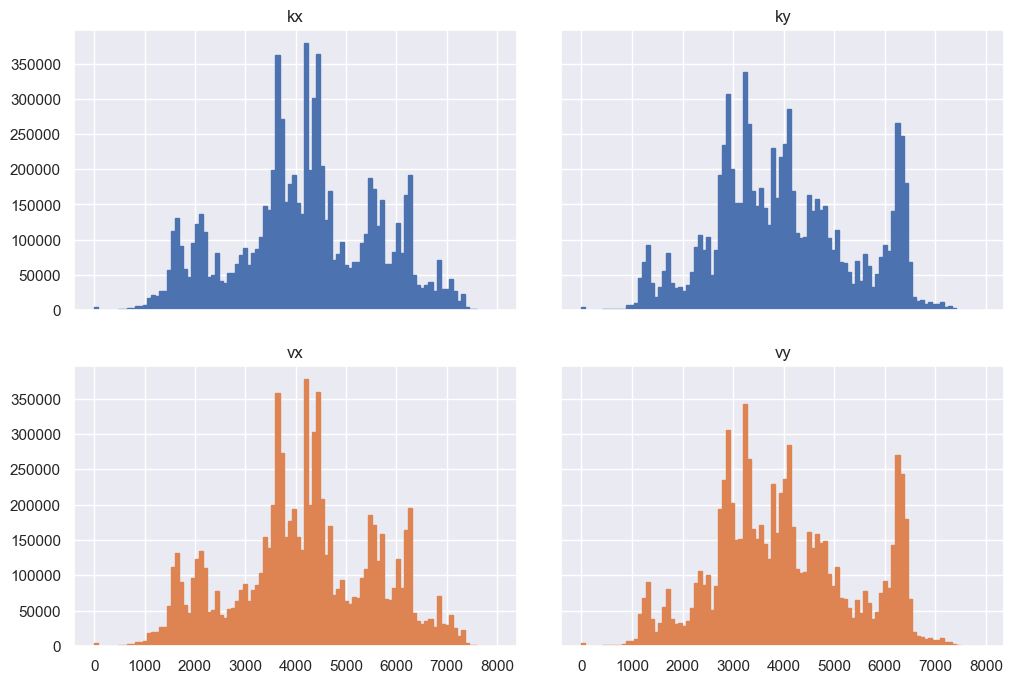

In [5]:
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize=(12, 8), sharex = 'col', sharey = 'row')
fig.subplots_adjust(wspace = 0.1)

axes[0][0].hist(df['kx'], bins = 100, edgecolor = 'C0')
axes[0][1].hist(df['ky'], bins = 100, edgecolor = 'C0')
axes[1][0].hist(df['vx'], bins = 100, color = 'C1', edgecolor = 'C1')
axes[1][1].hist(df['vy'], bins = 100, color = 'C1', edgecolor = 'C1')

axes[0][0].set_title('kx')
axes[0][1].set_title('ky')
axes[1][0].set_title('vx')
axes[1][1].set_title('vy');

Cả 4 cột tọa độ đều phân bố trong khoảng từ 0 tới 8000:
- Tọa độ tập trung của killer và victim nhìn chung khá giống nhau
- Đối với các tọa độ x, có khoảng 3 cụm đỉnh lần lượt ở `1500 - hơn 2000`, `3500 - 4500` và `5500 - 6500`
- Đối với các tọa độ y, có một cụm đỉnh lớn trong khoảng `3000 - 4500` và một đỉnh riêng lẻ ở khoảng `6500`
- Vị trí của các cụm sẽ được giải thích ở phần sau, khi nhóm sử dụng nhiều các visualization hơn.

### 2.2.2. Cột dis

<AxesSubplot:xlabel='dis', ylabel='Count'>

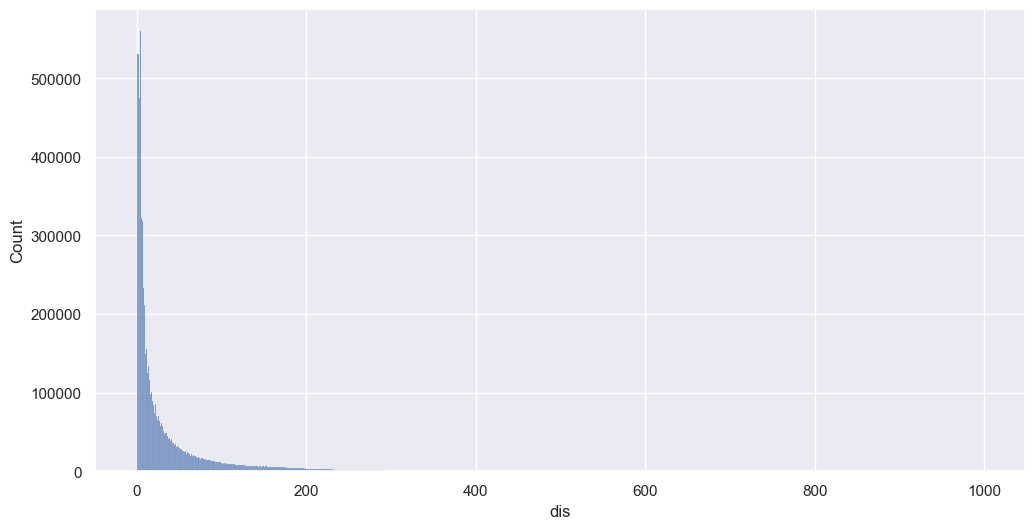

In [6]:
fig = plt.figure(figsize=(12, 6))

sns.histplot(df['dis'], bins = 1000)

Cột `dis` phân bố từ 0 tới 1000 (do nhóm đã thực hiện lọc ở phần Data Preprocessing), tập trung cao nhất ở mức 0, số lượng kill giảm dần khi dis tăng lên (có vẻ là theo hàm log)

### 2.2.3. Cột `time` và `phase`

Text(0.5, 1.0, 'phase')

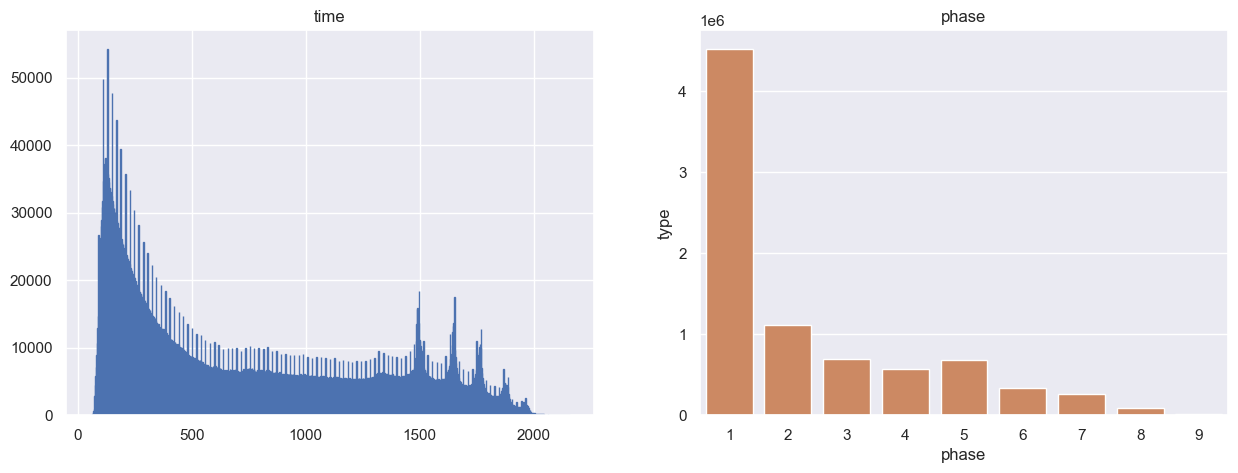

In [7]:
fig, axes = plt.subplots(ncols = 2, figsize = (15, 5))

axes[0].hist(df['time'], bins = 1000, edgecolor = 'C0')

data = df.groupby(by = ['phase']).count().reset_index()[['phase', 'type']]
sns.barplot(data = data, x = 'phase', y = 'type', ax = axes[1], color = 'C1')

axes[0].set_title('time')
axes[1].set_title('phase')

- Đa số kill diễn ra ở phase 1, giảm dần ở các phase tiếp theo. Có thể do ở phase 1, các player vừa nhảy dù xuống, nhiều player sẽ nhảy dù vào cùng những địa điểm thuận lợi, dẫn tới giao tranh xảy ra vào phase 1 là cao nhất. Sau đó nhiều player tử trận, giao tranh giảm xuống, số lượng kill cũng giảm theo
- Khi quan sát histogram của time, ta nhận thấy có một số đỉnh cao đột ngột từ khoảng 1500s trở về sau, khi xem xét bảng thời gian bắt đầu và kết thúc của các phase dưới đây, ta nhận ra thời điểm kill tăng lên là ở các khoảng thời gian chuyển tiếp từ phase này sang phase kia, khi vòng bluezone thu vào, buộc người chơi phải di chuyển khỏi các nơi trú ẩn. Thêm vào đó là số lượng kill gây ra bởi sát thương từ bluezone, dẫn tới số lượng kill tăng cao. Nhóm kết hợp các đường khoảng đánh dấu phase ở histogram bên dưới để làm nổi bật điều này

|Phase|Bắt đầu|Kết thúc|
|-----|-------|--------|
|1|121|720|
|2|721|1060|
|3|1061|1300|
|4|1301|1480|
|5|1481|1650|
|6|1651|1760|
|7|1761|1880|
|8|1881|1970|
|9|1971|2150|

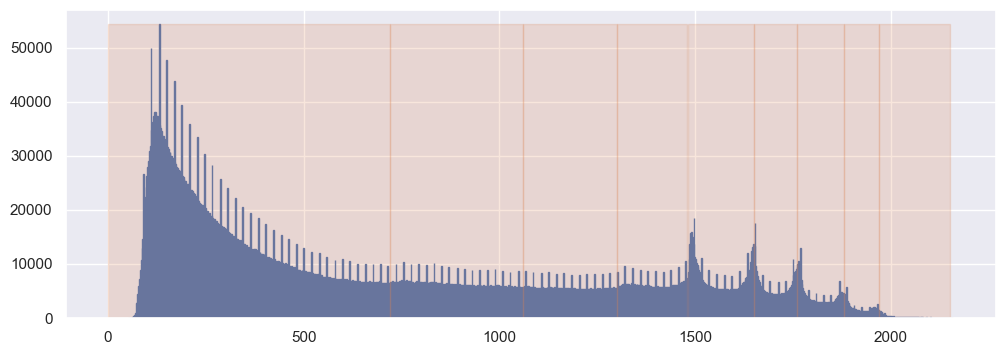

In [8]:
fig, ax = plt.subplots(figsize=(12, 4))

y, _, _ = plt.hist(df['time'], bins = 1000, edgecolor = 'C0')

phase_rect = [(0, 720), (721, 1060), (1061, 1300), (1301, 1480), (1481, 1650), (1651, 1760), (1761, 1880), (1881, 1970), (1971, 2150)]

for rect in phase_rect:
    ax.add_patch(patches.Rectangle((rect[0], 0), rect[1] - rect[0], y.max(), color = 'C1', alpha = 0.2))

### 2.2.4. Cột `killed_by` và `type`

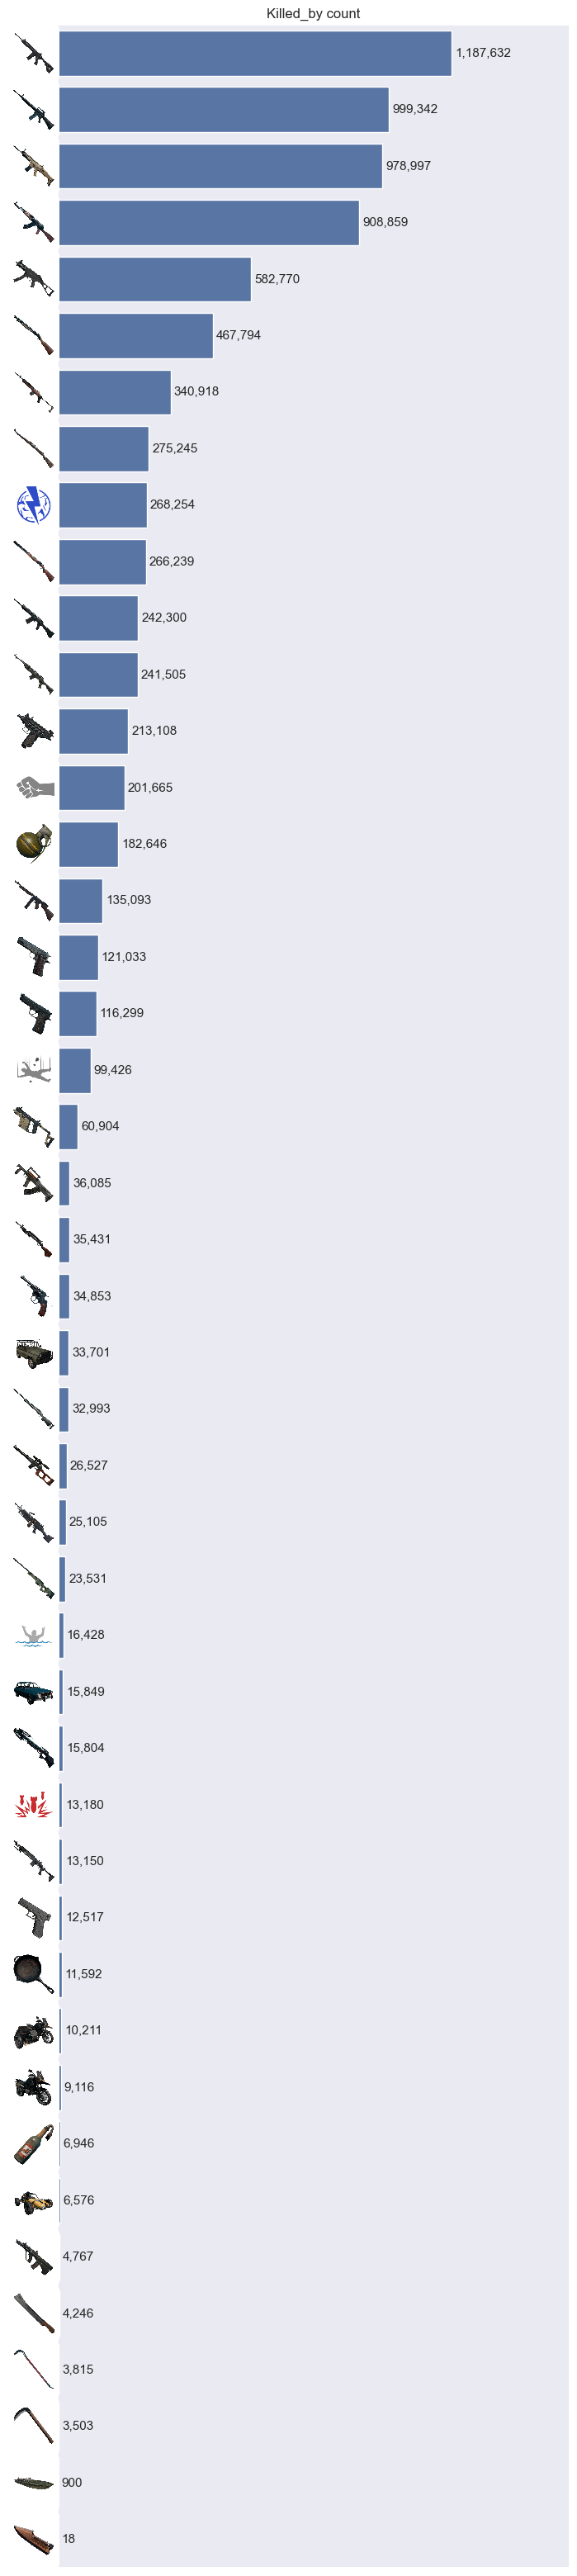

In [9]:
data = df['killed_by'].value_counts().reset_index()

fig, ax = plt.subplots(figsize=(8, 40))
ax = sns.barplot(data = data, x = 'killed_by', y = 'index', color = 'C0')

ax.set_xlim(0, data['killed_by'].max() * 1.3)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.grid(visible = False)
ax.set_title('Killed_by count')

#annotate the bars
for i, v in enumerate(data['killed_by']):
    ax.text(v + 10000, i, f'{v:,}', va = 'center', fontsize = 11)

#use asset item as tick labels
for i, v in enumerate(data['index']):  
    img = plt.imread('asset/item/' + v +'.png', format = 'png')

    imagebox = OffsetImage(img, zoom = 0.07)
    imagebox.image.axes = ax

    ab = AnnotationBbox(imagebox, (0, 0),
                        xybox=(-10000, i),
                        xycoords=("data"),
                        box_alignment = (1, 0.5),
                        bboxprops = {'edgecolor': 'none'})

    ax.add_artist(ab)

# plt.savefig('visualization/killed_by_count.png', dpi = 300, bbox_inches = 'tight')

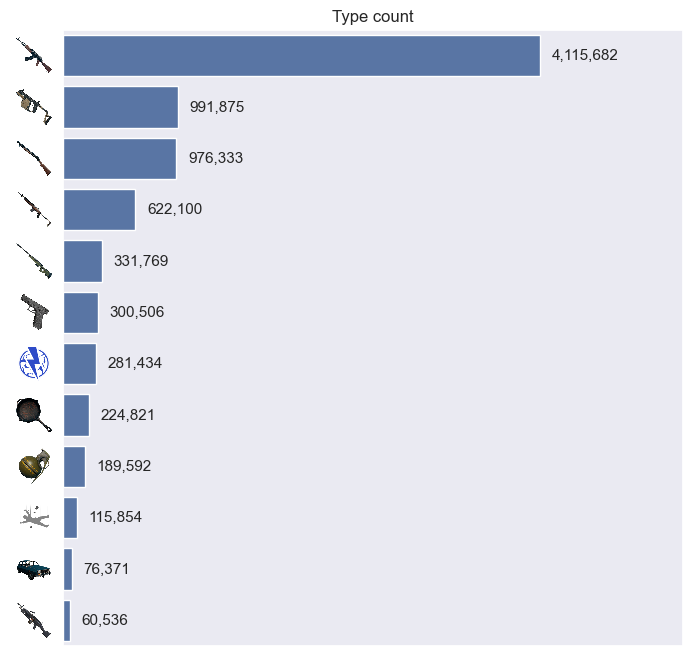

In [10]:
data = df['type'].value_counts().reset_index()

fig, ax = plt.subplots(figsize=(8, 8))
ax = sns.barplot(data = data, x = 'type', y = 'index', color = 'C0')

ax.set_xlim(0, data['type'].max() * 1.3)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.grid(visible = False)
ax.set_title('Type count')

#annotate the bars
for i, v in enumerate(data['type']):
    ax.text(v + 100000, i, f'{v:,}', va = 'center', fontsize = 11)

#use icon as tick labels
for i, v in enumerate(data['index']):  
    img = plt.imread('asset/type_item/' + v +'.png')

    imagebox = OffsetImage(img, zoom = 0.05)
    imagebox.image.axes = ax

    ab = AnnotationBbox(imagebox, (0, 0),
                        xybox=(-100000, i),
                        xycoords=("data"),
                        box_alignment = (1, 0.5),
                        bboxprops = {'edgecolor': 'none'})

    ax.add_artist(ab)

plt.savefig('visualization/type_count.png', dpi = 300, bbox_inches = 'tight')

- Đa số kill được gây ra bởi các súng AR với hơn 4 triệu kill, theo sau đó là SMG và Shotgun với số lượng kill xấp xỉ nhau khoảng gần 1 triệu kill
- các loại súng nhắm DMR và SR xếp hạng 4 và 5 với lần lượt hơn 600,000 và hơn 300,000 kill
- Đáng chú ý số lượng kill gây bởi Handgun nhiều hơn cả Bluezone và Redzone cộng lại
- Vũ khí cận chiến gây hơn 200,000 kill trong khi vũ khí ném chỉ gây gần 190,000 kill
- Số player tử trận bởi đuối nước và té ngã nhiều hơn cả số player bị tông bởi các loại xe
- Súng máy hạng nhẹ LMG gây ra ít kill nhất, khoảng 60,000 kill

## 2.3. Phân bố dữ liệu giữa các cột với nhau
### 2.3.1. Đếm `killed_by` theo từng `type`
Dù nhóm đã trực quan hóa số lượng các giá tị trong `killed_by` ở trên nhưng do số lượng các giá trị này quá lơn, do đó ta có thể đếm số lượng các `killed_by` theo từng `type`

In [11]:
datas = [
    df[df['type'] == 'AR']['killed_by'].value_counts().reset_index(),
    df[(df['type'] == 'SMG') | (df['type'] == 'Shotgun')]['killed_by'].value_counts().reset_index(),
    df[(df['type'] == 'DMR') | (df['type'] == 'SR')]['killed_by'].value_counts().reset_index(),
    df[(df['type'] == 'Handgun')]['killed_by'].value_counts().reset_index(),
    df[(df['type'] == 'Melee')]['killed_by'].value_counts().reset_index(),
    df[(df['type'] == 'Throwable') | (df['type'] == 'Zone') | (df['type'] == 'Self') | (df['type'] == 'LMG')]['killed_by'].value_counts().reset_index()
]

titles = ['AR', 'SMG & Shotgun', 'DMR & SR', 'Handgun', 'Melee', 'Throwable & Zone & Self & LMG']

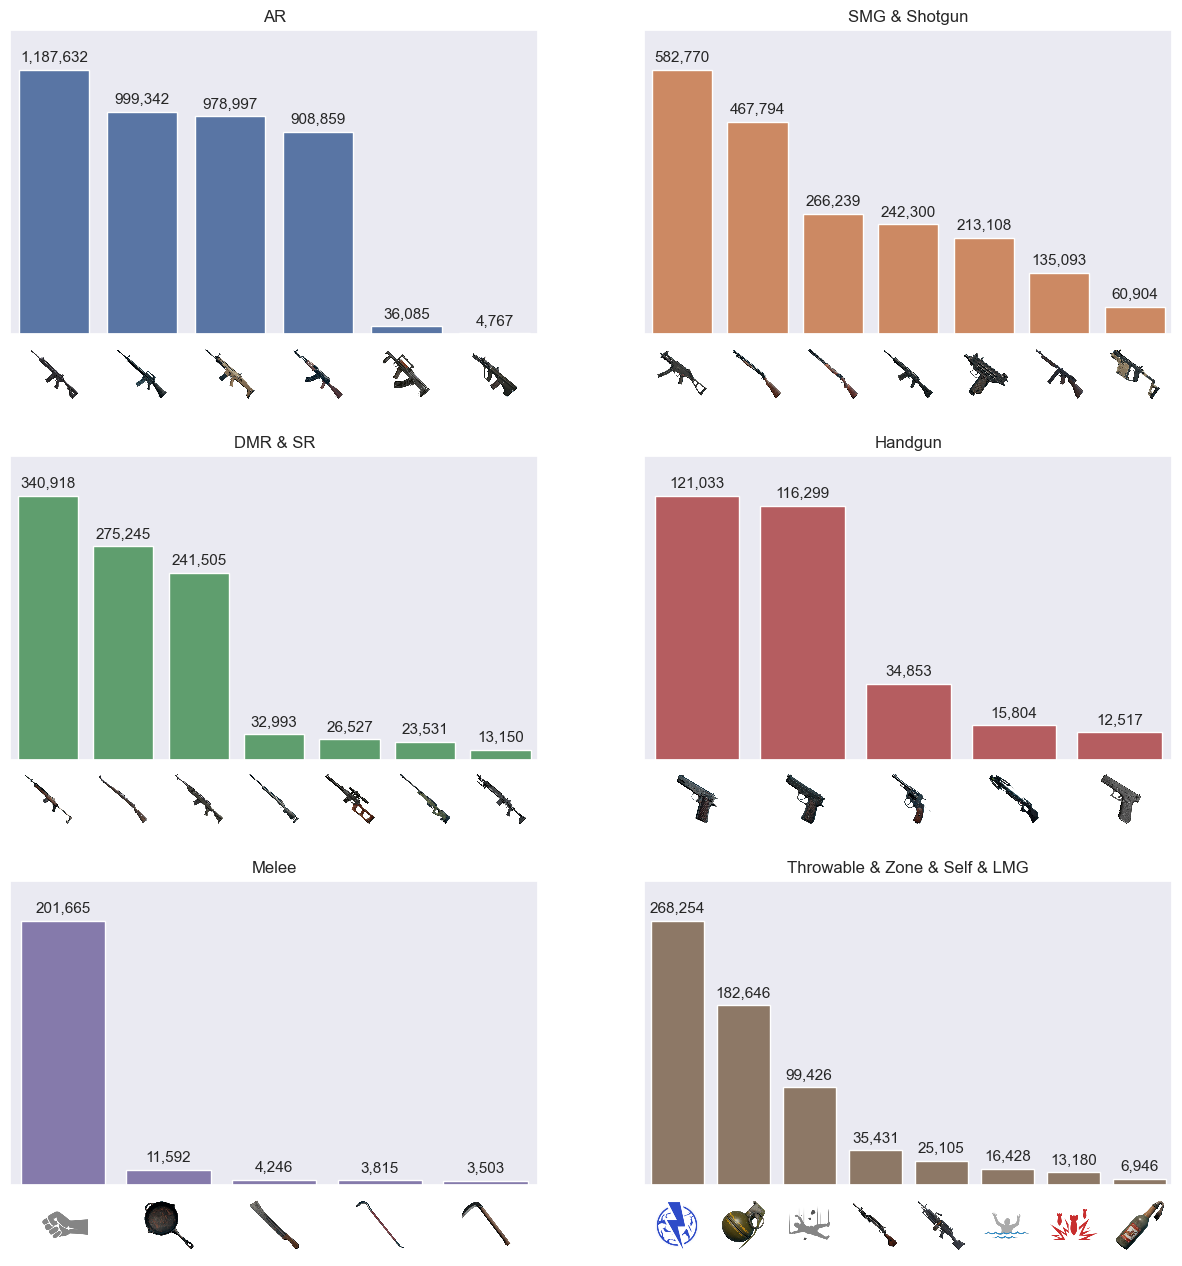

In [12]:
fig, axes = plt.subplots(ncols = 2, nrows = 3, figsize = (15, 15))
fig.subplots_adjust(hspace = 0.4)

for i, ax in enumerate(axes.flat):
    sns.barplot(data = datas[i], x = 'index', y = 'killed_by', ax = ax, color = f'C{i}')
    ax.set_title(titles[i])

    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_yticklabels([])
    ax.grid(visible = False)
    
#annotate the bars
for ax in axes.flat:
    max_h = max([v.get_height() for v in ax.patches])
    ax.set_ylim(0, max_h * 1.15)
    for j, v in enumerate(ax.patches):
        ax.text(v.get_x() + v.get_width() / 2, v.get_height() + max_h * 0.03, f'{int(v.get_height()):,}', ha = 'center', fontsize = 11)

#use asset item as tick labels
for ax in axes.flat:
    max_h = max([v.get_height() for v in ax.patches])
    for i, v in enumerate(ax.get_xticklabels()):
        img = plt.imread('asset/item/' + v.get_text() +'.png', format = 'png')

        imagebox = OffsetImage(img, zoom = 0.07)
        imagebox.image.axes = ax

        ab = AnnotationBbox(imagebox, (0, 0),
                            xybox=(i, -max_h * 0.15),
                            xycoords=("data"),
                            box_alignment = (0.5, 0.5),
                            bboxprops = {'edgecolor': 'none'})

        ax.add_artist(ab)
    ax.set_xticklabels([])

#save the figure
for ax in axes.flat:
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f'visualization/killed_by_count_by_{ax.get_title()}.png', dpi = 300, bbox_inches = transforms.Bbox(extent.get_points() + [[-0.2, -0.7], [0.2, 0.3]]))

### 2.3.2. Đếm `type` theo `time`

In [13]:
data = df[['type', 'time', 'killed_by']].groupby(by = ['type', 'time']).count().reset_index()
data.columns = ['type', 'time', 'count']

In [14]:
data['type'].value_counts()[0:5].index

Index(['AR', 'SMG', 'Throwable', 'DMR', 'Shotgun'], dtype='object')

Text(0.5, 1.0, 'Top 6 upper of Type count by time')

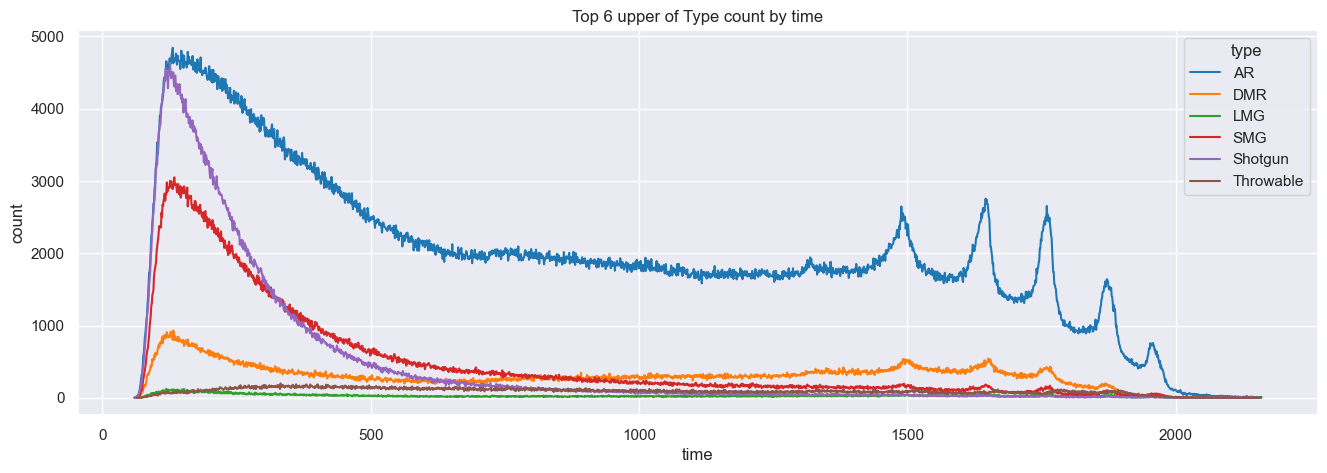

In [15]:
plt.figure(figsize = (16, 5))
sns.lineplot(data = data[data['type'].isin(data['type'].value_counts()[0:6].index)], x = 'time', y = 'count', hue = 'type', palette = 'tab10')
plt.title('Top 6 upper of Type count by time')

- Đa phần các `type` có số lượng tuân theo tổng số kill theo thời gian: cao ở giai đoạn đầu, giảm dần qua thời gian và tăng cao đột ngột ở các giai đoạn chuyển phase.
- Thứ hạng của các `type` hầu như giữ nguyên theo thời gian, trừ:
    - `Shotgun` sau khi giữ top 2 trong khoảng 750s đầu trận rơi dần xuống top 6 ở giai đoạn cuối trận. Giải thích: `Shotgun` là gây sát thương rất cao nhưng tầm bắn rất ngắn, phù hợp với giai đoạn đầu trận khi giao tranh xảy ra ở các công trình, khoảng cách giao tranh nhỏ, số lượng player đông, cần phải xử lí nhanh. Khi trận đấu dần ổn định, các player giữ khoảng cách xa, shotgun gần như không có tác dụng.
    - `SMG` nắm giữ top 3, sau đó vươn lên top 2 khi `Shotgun` rơi xuống top 3, sau đó tiếp tục rơi xuống top 3 khi `DMR` vươn lên top 2. Nguyên nhân cũng giống `Shotgun`, `SMG` là súng tiểu tiên, tốc độ ra đạn cực kì nhanh, có khả năng gây sát thương lớn trong khoảng thời gian ngắn ở khoảng cách gần, được sử dụng nhiều ở giai đoạn đầu trận. Ở các giai đoạn sau `SMG` mất ưu thế khi khoảng các của các player tăng lên, tuy nhiên `SMG` vẫn hiệu quả hơn `Shotgun` (tầm bắn xa hơn, liên thanh) nên vẫn nắm giữ top 3.
    - `DMR` giữ top 4 ở giai đoạn đầu trận, sau đó từ phase 2 trở đi dần dần leo lên top 2. Giải thích: `DMR` là súng bắt tỉa theo cơ chế semi-sniper (bắn từng viên), tuy gây sát thương tương đối cao nhưng không thích hợp giao tranh tầm gần, rất gần (do cần gây sát thương lên kẻ thù với tốc độ nhanh) nên khó gây nhiều kill ở giai đoạn đầu. Ở giai đoạn sau, khi các player ổn định vị trí ở các khoảng cách tương đối, `DMR` phát huy ưu thế hơn so với `SMG` và `Shotgun`.

<iframe src='https://gfycat.com/ifr/HairyValidAmurminnow' frameborder='0' scrolling='no' allowfullscreen width='640' height='404'></iframe>

<iframe src='https://gfycat.com/ifr/GlisteningBonyEeve' frameborder='0' scrolling='no' allowfullscreen width='640' height='404'></iframe>

<iframe src='https://gfycat.com/ifr/WarlikeWhichChihuahua' frameborder='0' scrolling='no' allowfullscreen width='640' height='404'></iframe>

Text(0.5, 1.0, 'Top 6 lower of Type count by time')

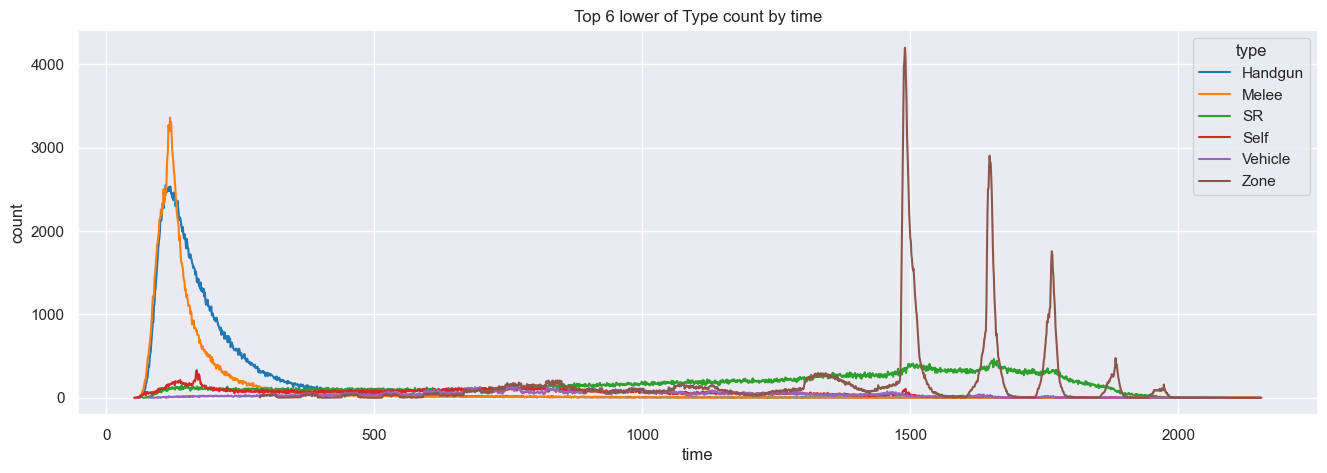

In [16]:
plt.figure(figsize = (16, 5))
sns.lineplot(data = data[data['type'].isin(data['type'].value_counts()[6:].index)], x = 'time', y = 'count', hue = 'type', palette = 'tab10')
plt.title('Top 6 lower of Type count by time')

- Tương tự với `SMG` và `Shotgun`, ở giai đoạn đầu trận, `Handgun` và `Melee` nắm giữ top đầu gây kill (do các player vừa đáp dù xuống mặt đất, bất kì thứ vũ khí gì có trong tay đều được sử dụng để tiêu diệt đối thủ, kể cả các cũ khí cầm tay và đấm tay không). Tất nhiên sau khi đã có súng, các player chỉ dùng súng để gây kill
- `Seft` có một đỉnh cao nhẹ ở giai đoạn đầu và ở giai đoạn 1500s (chuyển phase) có thể do ở giai đoạn đầu lầ giai đoạn đáp dù (dễ đáp dù lỗi, vướng vào các tòa nhà, cây cao) và di chuyển giữa các kiến trúc nhiều (nhảy qua lại giữa các tòa nhà, nhảy từ tầng cao xuống để giao tranh/tránh giao tranh) dẫn đến nhiều player tử trận vì té ngã. Ở giai đoạn chuyển phase 5, nhiều player trong quá trình di chuyển có thể bị té ngã từ các vách núi, công trình hoặc đuối nước trong lúc né tránh kẻ thù khi đang bơi
- `Zone` đặt biệt cao ở các giai đoạn chuyển phase, khi Bluezone bắt đầu thu vào, nhiều player mắc kẹt ở ngoài vòng xanh, bị gây sát thương dẫn đới tử trận

<iframe src='https://gfycat.com/ifr/IncompleteSpotlessAfricanparadiseflycatcher' frameborder='0' scrolling='no' allowfullscreen width='640' height='404'></iframe>

<iframe src='https://gfycat.com/ifr/WelllitAcclaimedFlyingfox' frameborder='0' scrolling='no' allowfullscreen width='640' height='404'></iframe>

<iframe src='https://gfycat.com/ifr/HelplessSpicyDugong' frameborder='0' scrolling='no' allowfullscreen width='640' height='404'></iframe>

<iframe src='https://gfycat.com/ifr/BriskApprehensiveHogget' frameborder='0' scrolling='no' allowfullscreen width='640' height='404'></iframe>

<iframe src='https://gfycat.com/ifr/AcrobaticMarvelousJavalina' frameborder='0' scrolling='no' allowfullscreen width='640' height='404'></iframe>

<iframe src='https://gfycat.com/ifr/SardonicUnfitFurseal' frameborder='0' scrolling='no' allowfullscreen width='640' height='404'></iframe>

### 2.3.3. Trung bình khoảng cách theo thời gian

<AxesSubplot:title={'center':'Average distance by time (included Bluezone)'}, xlabel='time'>

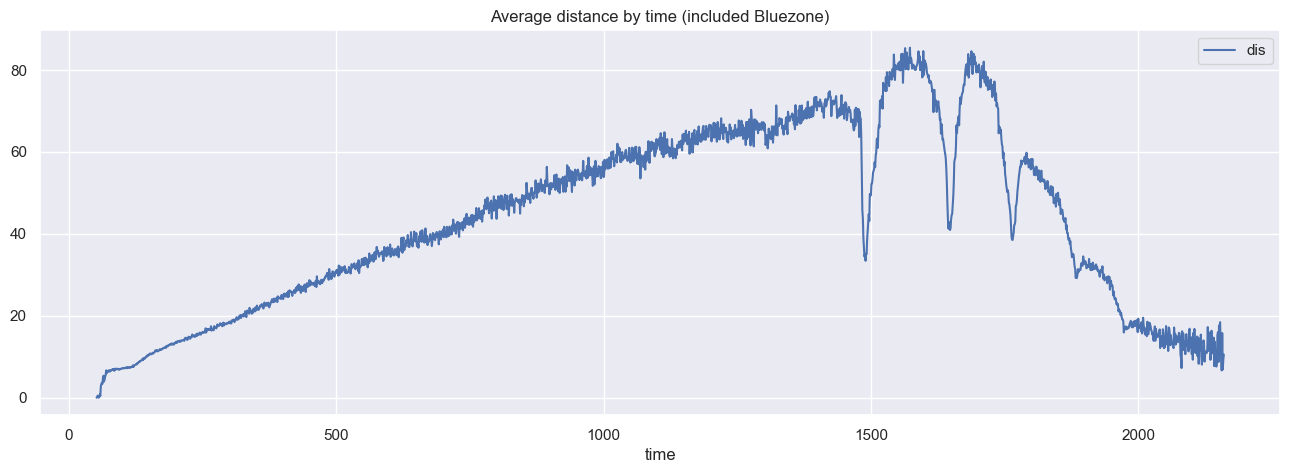

In [17]:
df[['time', 'dis']].groupby(by = ['time']).mean().plot(figsize = (16, 5), title = 'Average distance by time (included Bluezone)')

<AxesSubplot:title={'center':'Average distance by time (excluded Bluezone)'}, xlabel='time'>

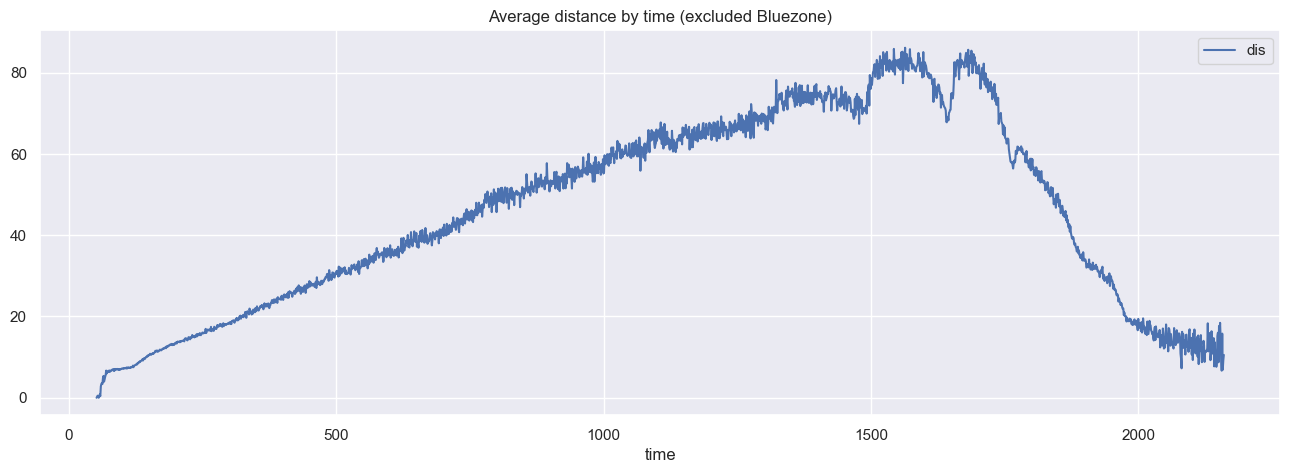

In [18]:
df[df['killed_by'] != 'BlueZone'][['time', 'dis']].groupby(by = ['time']).mean().plot(figsize = (16, 5), title = 'Average distance by time (excluded Bluezone)')

- Khoảng cách trung bình của các kill gây ra thấp ở đầu trận, khi các player vừa đáp dù xuống đất, va chạm với nhau ở các khu vực công trình thuận lợi, vị trí có xe. Thêm vào đó là ở giai đoạn này các player chưa thu thập được nhiều trang bị như ống ngắm, giảm giật nên việc gây kill ở khoảng cách xa cũng rất ít. Do đó khoảng cách trung bình ở giai đoạn này thấp

- Sau đó khi trận đấu ổn định, các player giữ khoảng cách với nhau, chuyển sang sử dụng AR, DMR và SR nhiều hơn thay vì các vũ khí tầm gần như SMG và Shotgun, do đó khoảng cách trung bình của các kill tăng lên. 

- Ta có thể thấy một vài đỉnh lõm xuống bất thường giống với các đỉnh tăng lên bất thường của số lượng kill theo thời gian ở các giai đoạn chuyển phase. Cùng lí do rằng khi chuyển phase, vòng bluezone sẽ ép các tuyển thủ di chuyển, trong nhiều trường hợp là ra khỏi các công trình kiến trúc và ca chạm nhau trong khoảng cách hẹp, do đó làm giảm khoảng cách trung bình của kill. Sau đó ở giai đoạn vòng bluezone đứng yên, các tuyển thủ lại tiếp tục gây kill ở khoảng cách xa. Thêm vào đó, các kill do bluezone gây ra ở giai đoạn này tăng vọt lên, mà khoảng cách kill của bluezone là bằng 0, do đó trung bình khoảng cách sẽ bị kéo xuống nhiều.

- Khi trận đấu tiến về cuối, bluezone thu hẹp lại nên khoảng cách gây kill cũng giảm dần theo

- Tuy nhiên ta có thể thấy sự bất thường khi khoảng dữ liệu từ giây thứ 2000 trở đi lại giãn rộng ra

Text(0.5, 1.0, 'Top 6 lower of Type average distance by time')

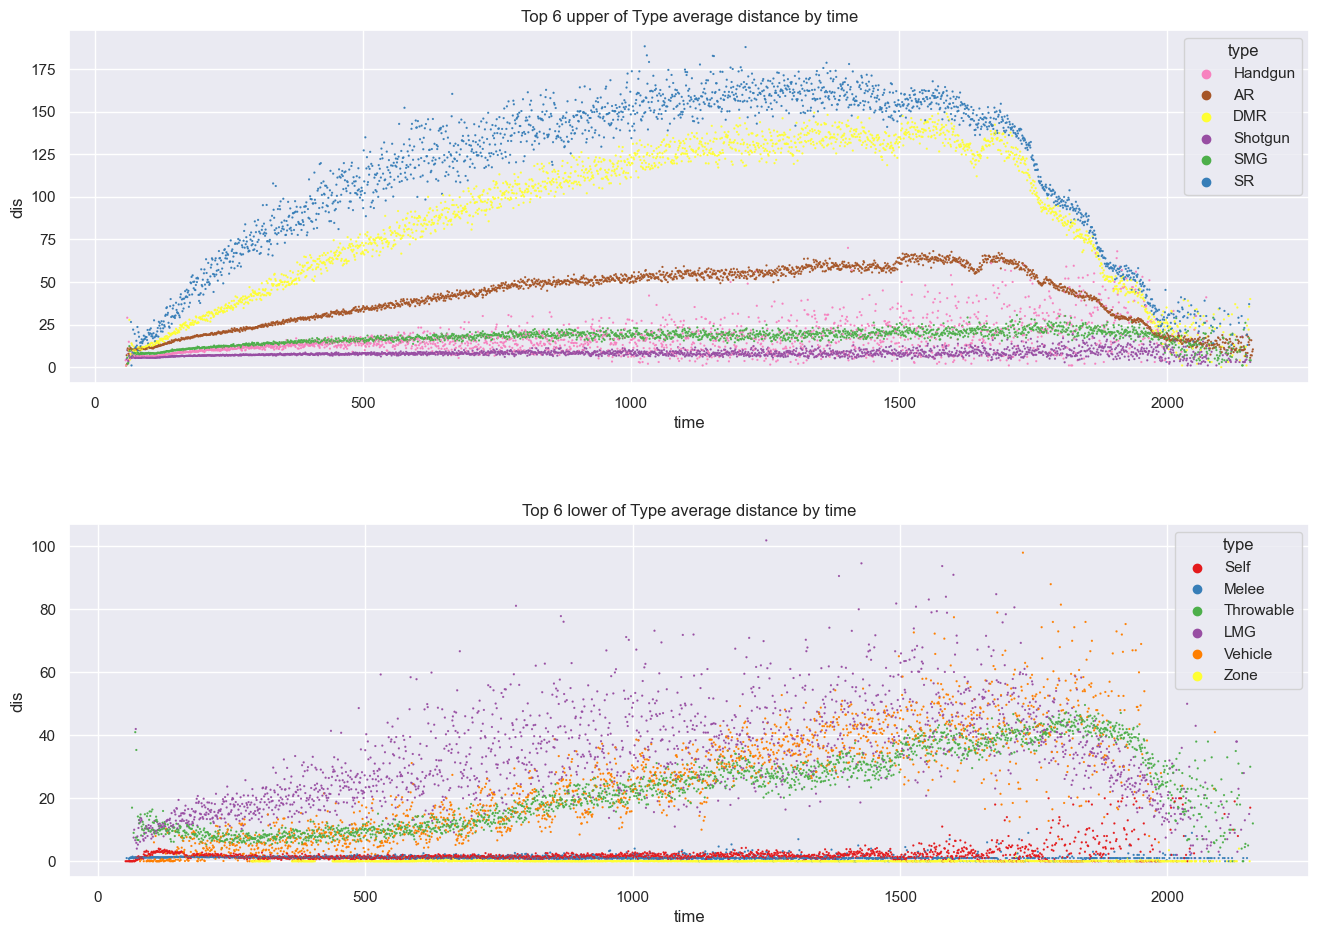

In [19]:
fig, axes = plt.subplots(nrows = 2, figsize = (16, 11))
fig.subplots_adjust(hspace = 0.4)

data = df[df['type'].isin(df['type'].value_counts()[0:6].index)][['time', 'type', 'dis']].groupby(by = ['time', 'type']).mean().reset_index()
sns.scatterplot(data = data, x = 'time', y = 'dis', hue = 'type', palette = 'Set1_r', ax = axes[0], s = 2, edgecolor = None)
axes[0].set_title('Top 6 upper of Type average distance by time')

data = df[df['type'].isin(df['type'].value_counts()[6:].index)][['time', 'type', 'dis']].groupby(by = ['time', 'type']).mean().reset_index()
sns.scatterplot(data = data, x = 'time', y = 'dis', hue = 'type', palette = 'Set1', ax = axes[1], s = 2, edgecolor = None)
axes[1].set_title('Top 6 lower of Type average distance by time')

### 2.3.4. Phân bố dữ liệu theo tọa độ (2 chiều)
Ở phần trước, nhóm đã biểu diễn phân bố của các cột tọa độ trên 1 chiều (trục ngang). Ở phần này nhóm sẽ biểu diễn phân bố các cột tọa độ theo 2 chiều. 

Text(0.5, 1.0, 'Victim position')

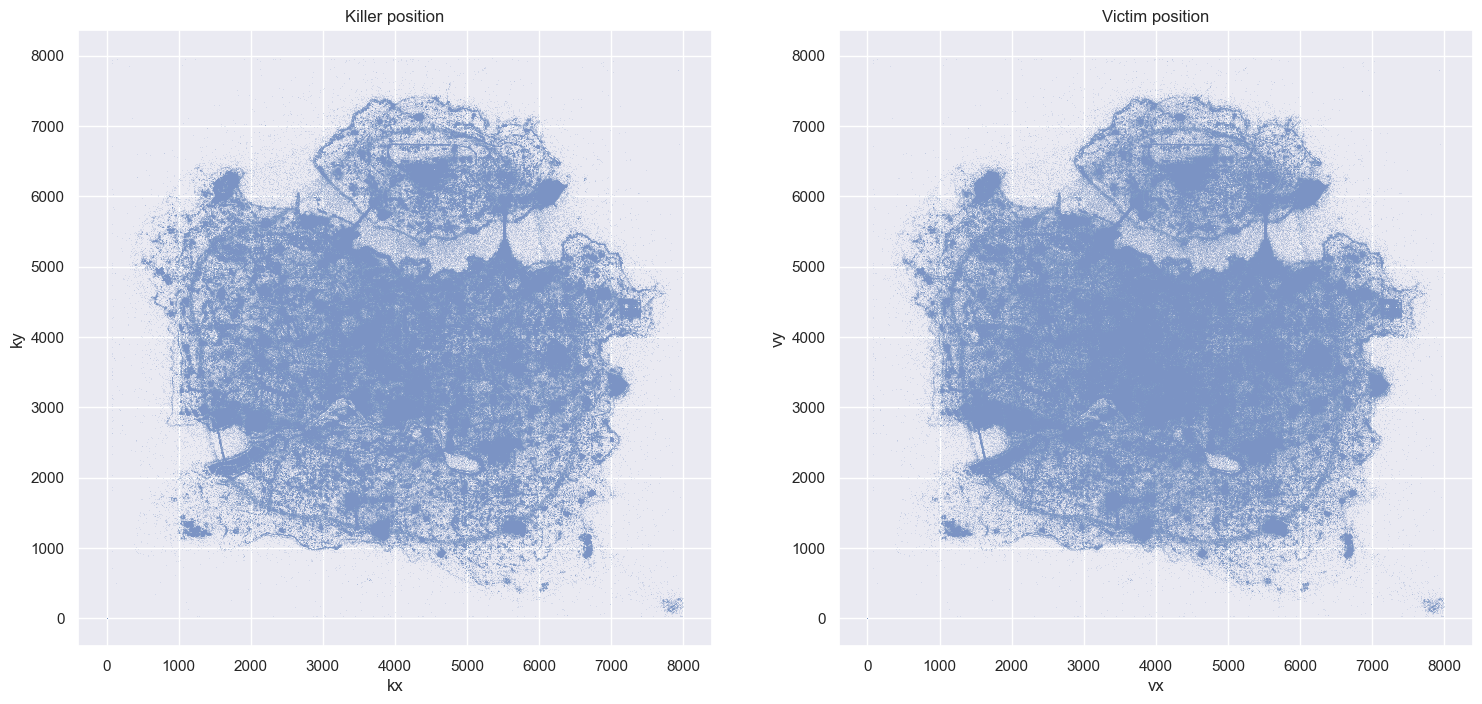

In [20]:
fig, axes = plt.subplots(ncols = 2, figsize = (18, 8))
sns.scatterplot(data = df, x = 'kx', y = 'ky', s = 0.1, ax = axes[0])
sns.scatterplot(data = df, x = 'vx', y = 'vy', s = 0.1, ax = axes[1])

axes[0].set_title('Killer position')
axes[1].set_title('Victim position')

Nhìn chung ta thấy phân bố của killer có vẻ phân bố rõ ràng các vùng đặc, rỗng hơn so với phân bố của victim. Có thể giải thích do các killer có xu hướng tập trung trong các công trình để gây kill còn victim thường có xu hướng tử trận ở đều các vị trí hơn

Quan sát phân bố của vị trí của killer và position, ta dễ dàng nhận ra dữ liệu phân bố theo hình dạng của bản đồ ERANGEL. Để trực quan hơn, nhóm ta có thể visualize đè lên bản đồ ERANGEL. 

<img src="asset/map/ERANGEL.png" alt="MarineGEO circle logo" style="height: 300px; width:300px;"/>

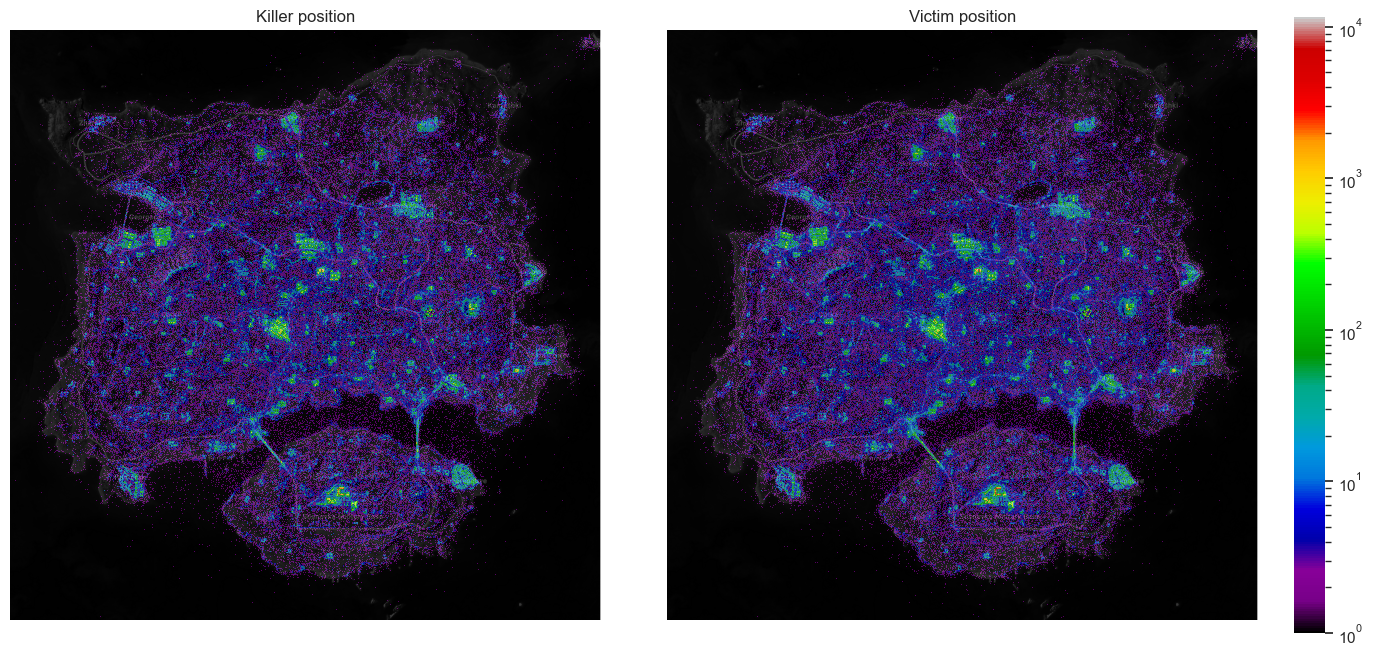

In [24]:
fig, axes = plt.subplots(ncols = 2, figsize = (18, 8), gridspec_kw={'width_ratios': [8, 10]})
fig.subplots_adjust(wspace = 0.1)
img = plt.imread('asset/map/ERANGEL.png')

number_of_bin = 1600

axes[0].imshow(img[::-1, :, 0], extent = [0, 1640, 0, 1640], alpha = 0.35, zorder = 3, cmap = 'gray')
axes[1].imshow(img[::-1, :, 0], extent = [0, 1640, 0, 1640], alpha = 0.35, zorder = 3, cmap = 'gray')

sns.heatmap(
    plt.hist2d(df['ky'], df['kx'], bins = number_of_bin, range = [[0, 8000], [0, 8000]])[0] + 1,
    cbar = False, cmap = 'nipy_spectral', ax = axes[0], norm = LogNorm())

axes[0].set_xticklabels([])
axes[0].set_yticklabels([])
axes[0].set_title('Killer position')

sns.heatmap(
    plt.hist2d(df['vy'], df['vx'], bins = number_of_bin, range = [[0, 8000], [0, 8000]])[0] + 1, 
    cmap = 'nipy_spectral', ax = axes[1], norm = LogNorm())

axes[1].set_xticklabels([])
axes[1].set_yticklabels([])
axes[1].set_title('Victim position')

plt.savefig('visualization/heatmap_position.png', dpi = 1200, bbox_inches = 'tight')

Trên đây là heatmap biểu diễn số lượng kill ở các khu vực với thang đo màu bên phải biểu hiện cho $log_{10}$ của số lượng kill tại 1 điểm. Ví dụ những điểm màu xanh dương sẽ có $10^1 = 10$ kill còn những điểm có màu đỏ sẽ có $10^3.5 \approx{3000}$ kill. Mỗi điểm ở đây là 1 khu vực hình vuông $5m*5m$. Sỡ dĩ nhóm không chia thành hình vuông $1m*1m$ là vì khi đó số lượng điểm trên bản đồ sẽ là $64 * 10^6$, bộ nhớ RAM của thành viên trong nhóm chỉ có 8GB, không thể xử lí tác vụ này.

Quan sát sơ bộ, ta có thể thấy lại điều đã nêu ở trên, vị trí của victim có xu hướng phủ rộng hơn (các vùng màu xanh có vẻ trải rộng hơn). Khi nhìn vào các khu vực nhỏ như Severny ở phía bắc, School ở trung tâm hay thành phố Georgopol ở phía tây bắc ta có thể thấy rõ điều này

Ta có thể thực hiện tương tự cho từng loại vũ khí để quan sát sự khác biệt giữa chúng

In [ ]:
datas = {kill_type : df[df['type'] == kill_type][['vx', 'vy']] for kill_type in df['type'].value_counts().index}
img = plt.imread('asset/map/ERANGEL.png')

In [ ]:
def heatmap_plot(kill_type):
    plt.figure(figsize = (10, 8))

    number_of_bin = 1600

    plt.imshow(img[::-1, :, 0], extent = [0, 1640, 0, 1640], alpha = 0.35, zorder = 3, cmap = 'gray')

    ax =  sns.heatmap(
        np.log(plt.hist2d(datas[kill_type]['vy'], datas[kill_type]['vx'], bins = number_of_bin, range = [[0, 8000], [0, 8000]])[0] + 1), 
        cmap = 'nipy_spectral', vmin = 0, vmax = 4)

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title('Victim position by ' + kill_type)
    ax.set_xlim(0, number_of_bin)
    ax.set_ylim(0, number_of_bin)
    ax.invert_yaxis()

    plt.savefig(f'visualization/heatmap_position_by_{kill_type}.png', dpi = 1200, bbox_inches = 'tight')

In [ ]:
for kill_type in df['type'].value_counts().index:
    heatmap_plot(kill_type)

### 2.3.5. Phân bố dữ liệu theo tọa độ và thời gian
Ở phần trên nhóm đã thực hiện trực quan hóa số lượng victim theo tọa độ, ở phần này nhóm tiếp tục phát triển thêm một chiều thời gian để thể hiện sự phân bố của victim trên bản đồ trong suốt trận đấu.

In [ ]:
img = plt.imread('asset/map/ERANGEL.png')

In [ ]:
%matplotlib inline

def ax_prunt(ax):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlim(0, number_of_bin)
    ax.set_ylim(0, number_of_bin)
    ax.invert_yaxis()

def init():
    sns.heatmap(np.zeros((number_of_bin, number_of_bin)), vmin = 0, vmax = 4, cmap = 'nipy_spectral', cbar = False)
    
    ax_prunt(ax)
def animate(i):
    data = df[df['time'].isin(range(i, i + 50))][['vx', 'vy']]
    data = np.log(plt.hist2d(data['vy'], data['vx'], bins = number_of_bin, range = [[0, 8000], [0, 8000]])[0] + 1)
    sns.heatmap(data, cmap = 'nipy_spectral', vmin = 0, vmax = 4, cbar = False)

    ax.set_title(f'{i}s - {i + 50}s')
    ax_prunt(ax)
    print(i)

fig, ax = plt.subplots(figsize = (10, 8))
number_of_bin = 1600
scale = number_of_bin / 1600 * 1640

plt.imshow(img[::-1, :, 0], extent = [0, scale, 0, scale], alpha = 0.35, zorder = 3, cmap = 'gray')
ax_prunt(ax)
sns.heatmap(np.zeros((number_of_bin, number_of_bin)), vmin = 0, vmax = 4, cmap = 'nipy_spectral')

anim = animation.FuncAnimation(fig, func = animate, init_func = init, interval = 20, frames = range(480, 630, 20), repeat = False)

start_time = time.time()

writer = animation.FFMpegWriter(fps=10)
anim.save('test6.mp4', writer=writer)

print(f'{time.time() - start_time:.2f} sec for saving video')  